In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get data
df = pd.read_csv('raw_data/horse_racing_raw.csv')

In [3]:
# Summary of features
df.describe()

,id,f_id,f_distance,f_class,f_age,f_pace,f_weight,f_runners,pred_isp,f_rating_rbd,...,f_pm_05m,f_pm_03m,f_pm_02m,f_pm_01m,f_bsp_p_back,f_bsp_p_lay,f_pm_01m_p_back,f_pm_01m_p_lay,f_pm_15m_p_back,f_pm_15m_p_lay
count,3.453630e+05,3.453630e+05,345363.000000,247337.000000,345363.000000,345212.000000,345363.000000,345363.000000,345363.000000,344502.000000,...,340767.000000,340871.000000,340964.000000,341004.000000,344998.000000,344998.000000,344645.000000,344645.000000,339848.000000,339847.000000
mean,1.648365e+13,1.648365e+13,12.868388,4.317680,5.093218,5.035178,142.507822,11.503514,45.883198,95.513393,...,58.479765,59.565013,60.758887,66.468253,-0.073724,-0.014167,-0.074028,-0.051324,-0.058990,-0.067163
std,2.559315e+11,2.559315e+11,6.344272,1.356204,2.240577,2.532917,15.058073,4.204376,501.069928,43.232524,...,150.242091,152.067616,154.959000,167.738294,6.360134,6.681553,6.294554,6.891922,6.152988,6.739348
min,1.604279e+13,1.604279e+13,5.000000,1.000000,2.000000,0.000000,112.000000,2.000000,1.020000,7.000000,...,1.020000,1.020000,1.020000,1.010000,-1.000000,-999.000000,-1.000000,-1009.000000,-1.000000,-1009.000000
25%,1.626150e+13,1.626150e+13,7.000000,4.000000,3.000000,3.000000,130.000000,8.000000,6.000000,78.000000,...,6.800000,6.800000,6.800000,6.800000,-1.000000,0.950000,-1.000000,0.950000,-1.000000,0.950000
50%,1.649248e+13,1.649248e+13,11.500000,5.000000,5.000000,5.000000,138.000000,11.000000,11.000000,101.000000,...,14.000000,14.000000,14.000000,14.500000,-1.000000,0.950000,-1.000000,0.950000,-1.000000,0.950000
75%,1.669476e+13,1.669476e+13,17.500000,5.000000,6.000000,7.000000,156.000000,14.000000,21.000000,123.000000,...,36.000000,36.000000,36.000000,38.000000,-1.000000,0.950000,-1.000000,0.950000,-1.000000,0.950000
max,1.692554e+13,1.692554e+13,34.500000,6.000000,18.000000,10.000000,182.000000,40.000000,9999.000000,237.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,949.050000,0.950000,949.050000,0.950000,949.050000,0.950000


In [4]:
# Determine the maximum date to calculate the start date for the test set
max_date = df['f_ko'].max()
max_date

'2023-08-20 18:45:00'

In [5]:
# Create test set over last year of dataset.

test_start_date = '2022-08-20 18:45:00'  # max_date - 1 yr

# Split the data
train = df[df['f_ko'] <= test_start_date]
test = df[df['f_ko'] > test_start_date]

len(train), len(test)

(224994, 120369)

In [6]:
print(f'There are {test.f_id.nunique()} races in the test dataset, at an average of {(len(test) / test.f_id.nunique()):.2f} horses per race')

There are 12699 races in the test dataset, at an average of 9.48 horses per race


In [12]:
# Create function that plots evolution of profits for betting £100 on the favourite, least favourite, or random horse for each race

def plot_baseline_profits(df):
    # Sort by date/time
    df = df.sort_values(by='f_ko')
    
    # Select required columns
    df_subset = df[['f_id', 'f_ko', 'f_pm_15m', 'f_pm_15m_p_back']]
    
    # For favourites
    df_sorted = df_subset.sort_values(by=['f_id', 'f_pm_15m'])
    df_favorites = df_sorted.groupby('f_id').first()
    df_favorites['cumulative_profit'] = df_favorites['f_pm_15m_p_back'].cumsum()
    df_favorites['cumulative_profit_100'] = df_favorites['cumulative_profit'] * 100

    #For least favourites
    df_sorted = df_subset.sort_values(by=['f_id', 'f_pm_15m'])
    df_least_favorites = df_sorted.groupby('f_id').last()
    df_least_favorites['cumulative_profit'] = df_least_favorites['f_pm_15m_p_back'].cumsum()
    df_least_favorites['cumulative_profit_100'] = df_least_favorites['cumulative_profit'] * 100
    
    # For random horses
    df_random_horses = df_subset.groupby('f_id').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
    df_random_horses['cumulative_profit'] = df_random_horses['f_pm_15m_p_back'].cumsum()
    df_random_horses['cumulative_profit_100'] = df_random_horses['cumulative_profit'] * 100

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(df_favorites) + 1), df_favorites['cumulative_profit_100'], label='Favourites')
    plt.plot(range(1, len(df_least_favorites) + 1), df_least_favorites['cumulative_profit_100'], label='Least Favourites')
    plt.plot(range(1, len(df_random_horses) + 1), df_random_horses['cumulative_profit_100'], label='Random Horses')
    plt.plot(range(1, len(df_favorites) + 1), [0] * (len(df_favorites)), label='No Bets')
    
    plt.title("Evolution of profit with £100 for favourite/least favourite/random horses")
    plt.xlabel("number of races")
    plt.ylabel("profit (£)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

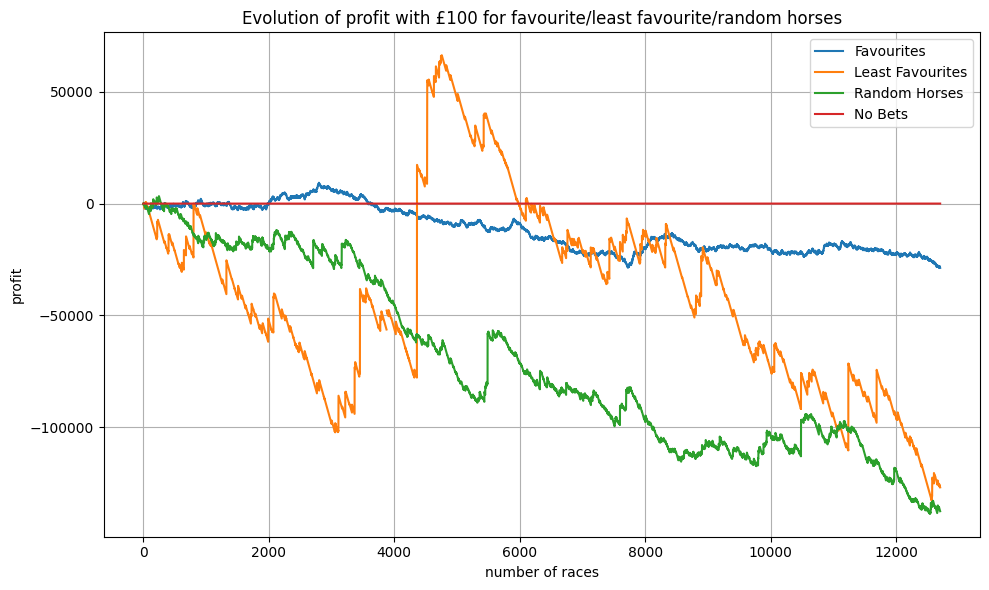

In [19]:
# Plot baseline profits for test data (nb. Random horses plot can change significantly each time you run function)

plot_baseline_profits(test)